In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms 
from torch.utils.data import DataLoader, random_split 
import matplotlib.pyplot as plt
import torchvision
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize images to a fixed size
    transforms.RandomHorizontalFlip(), # Randomly flip images horizonatally
    transforms.RandomRotation(10), # randomly rotate images
    transforms.ToTensor(), # convert images to pytorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalize to range [-1, 1]
])

dataset = datasets.ImageFolder(root='./images', transform=transform)

len(dataset)

9144

In [8]:
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size

train_size, test_size

(7315, 1829)

In [9]:

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

len(train_dataset), len(test_dataset)

(7315, 1829)

In [10]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 128, 128])
torch.Size([32])


In [12]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

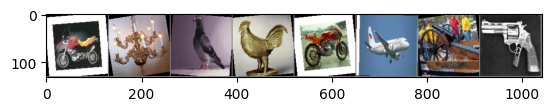

In [14]:
imshow(torchvision.utils.make_grid(images[:8]))

In [15]:
[dataset.classes[i] for i in labels[:8]]

['Motorbikes',
 'chandelier',
 'pigeon',
 'rooster',
 'Motorbikes',
 'airplanes',
 'cannon',
 'revolver']

In [20]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3,3), padding='same'), # output (32, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(stride=(2,2), kernel_size=(2,2)), # output (32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=(3,3), padding='same'), # output (64, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(stride=(2,2), kernel_size=(2,2)), # output (64, 32, 32)
            
            nn.Flatten(),
            nn.Linear(64*32*32, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.network(x)

In [24]:
# Training Loop
def train_model (model, optimizer, criterion, train_loader, test_loader, num_epochs=5): 
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f" Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len (train_loader): .4f}")

In [25]:
num_classes = len(dataset.classes)
num_classes

102

In [26]:
model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=5)

 Epoch [1/5], Loss:  3.4511
 Epoch [2/5], Loss:  2.5426
 Epoch [3/5], Loss:  2.0460
 Epoch [4/5], Loss:  1.7011
 Epoch [5/5], Loss:  1.4310


In [30]:
def test_model (model, test_loader): #Evaluation Loop 
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100* correct / total:.2f}%")

In [31]:
test_model(model, test_loader)

Test Accuracy: 53.91%


In [32]:
from torchvision import models

model_resnet = models.resnet18(weights='DEFAULT')

model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ahmad/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 40.2MB/s]


In [35]:
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model_resnet.parameters(), lr=0.001)

In [36]:
train_model(model_resnet, optimizer, criterion, train_loader, test_loader, num_epochs=5)

 Epoch [1/5], Loss:  2.1134
 Epoch [2/5], Loss:  1.0979
 Epoch [3/5], Loss:  0.7828
 Epoch [4/5], Loss:  0.6140
 Epoch [5/5], Loss:  0.4792


In [37]:
test_model(model_resnet, test_loader)

Test Accuracy: 75.78%


In [40]:
model_efficient_net = models.efficientnet_b0(weights='DEFAULT')
model_efficient_net.classifier[1] = nn.Linear(model_efficient_net.classifier[1].in_features, num_classes)

In [41]:
model_efficient_net = model_efficient_net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model_efficient_net.parameters(), lr=0.001)

In [42]:
train_model(model_efficient_net, optimizer, criterion, train_loader, test_loader, num_epochs=5)

 Epoch [1/5], Loss:  1.4783
 Epoch [2/5], Loss:  0.5342
 Epoch [3/5], Loss:  0.3639
 Epoch [4/5], Loss:  0.2708
 Epoch [5/5], Loss:  0.2097


In [43]:
test_model(model_efficient_net, test_loader)

Test Accuracy: 87.37%
